# CSYE 7105 - High Perfoamnce Machine Learning & AI - Project - Team 4 

## Analysis of Efficient Parallel Computing for Deep Learning-Based Glaucoma Detection

### Run time, Speed Up  , Efficiency and much more for GPU Training 

In [1]:
import os
import json
import matplotlib.pyplot as plt
from IPython.display import Image
import numpy as np

### Part 1 Serial Processing Analysis

#### Training Loss

In the following figures, you can see the training and validation performance of the model over 10 epochs while training on a single GPU for the Glaucoma dataset.

Loss Curves (Left): The plot on the left shows both the training and validation loss over the epochs. As expected, the training loss (blue line) decreases consistently, indicating the model is effectively learning from the training data. The validation loss (orange line) also decreases, though it begins to plateau after a few epochs. This suggests the model might be reaching a point of diminishing returns in terms of improving on unseen data.

Accuracy Curves (Right): The right plot shows the accuracy for both training and validation sets. The training accuracy (blue line) steadily increases, which shows the model is getting better at classifying the training data. The validation accuracy (orange line) also improves but at a slower pace, which could indicate some overfitting, as the model learns more about the training data than generalizing to new data.

Overall, the curves indicate that the model is learning well from the training data and improving its performance on validation data, although there’s some room for further optimization to handle the generalization better.

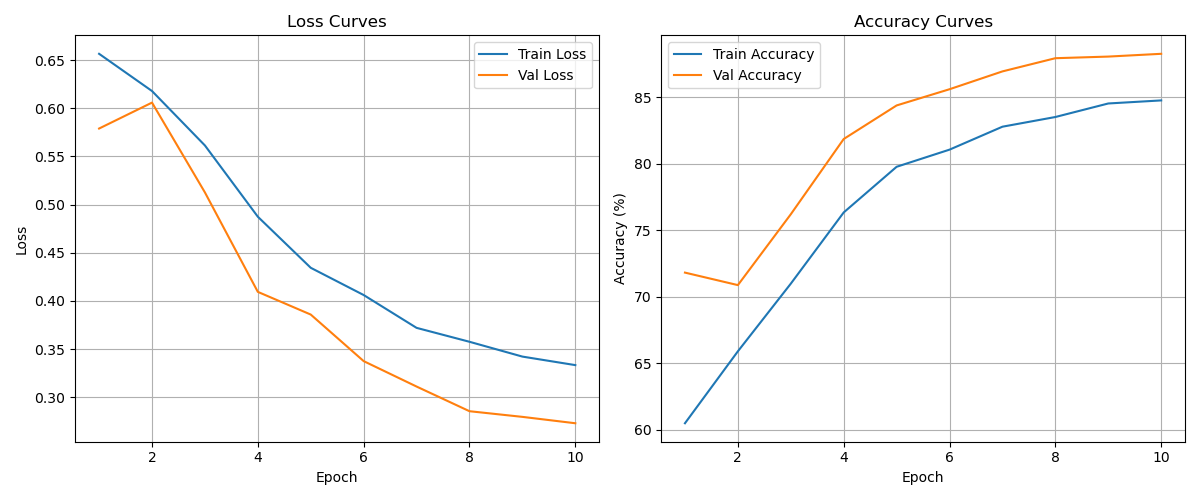

In [2]:
training_loss_path = "../SerialProcessing/gpu/plots/training_using_gpus_1_results.png"
Image(filename=training_loss_path)

### Comparing Runtime between V100-SXM2 , P100 and V100-SXM2-with-AMP

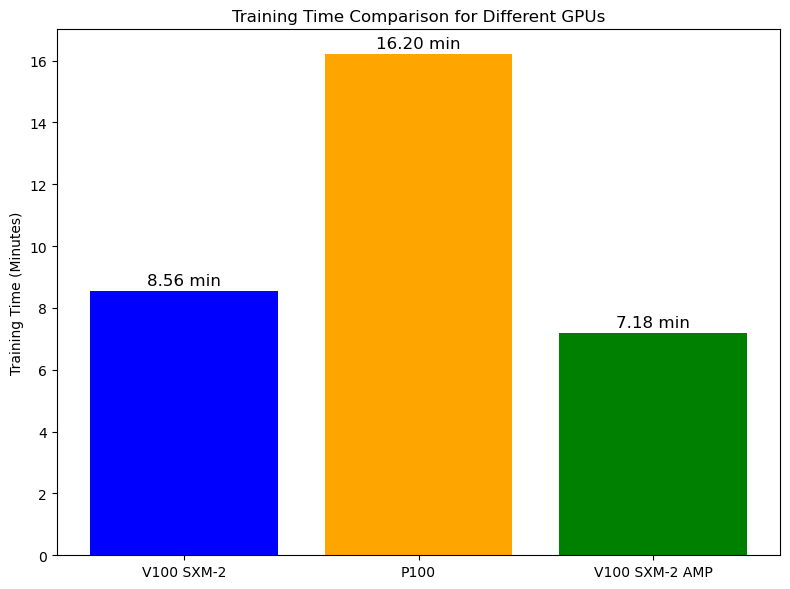

In [3]:
import json
import matplotlib.pyplot as plt

# File paths for the three JSON files
file_paths = [
    "../SerialProcessing/gpu/metrics/training_using_gpus_1_params.json",
    "../SerialProcessing/gpu/metrics/training_using_gpus_1_params_p100.json",
    "../SerialProcessing/gpu/metrics/training_using_gpus_1_amp_params.json"
]

# Names for the labels in the bar chart
labels = ['V100 SXM-2', 'P100', 'V100 SXM-2 AMP']

# Extracting training time from each JSON file
training_times = []

for file_path in file_paths:
    with open(file_path, 'r') as f:
        data = json.load(f)
        training_time = data.get('computing_time', 0)
        # Convert training time from seconds to minutes
        training_times.append(training_time / 60)

# Plotting the comparison of training times in minutes
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, training_times, color=['blue', 'orange', 'green'])
plt.ylabel('Training Time (Minutes)')
plt.title('Training Time Comparison for Different GPUs')


for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.1, f'{height:.2f} min', 
             ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

This above chart compares the training times for three different GPU configurations used for training the Glaucoma classification model. The comparison is based on the total time taken in minutes:

**V100 SXM-2** : The training time for this GPU configuration was approximately 8.56 minutes.

**P100** : This configuration showed the highest training time at 16.20 minutes.

**V100 SXM-2 AMP** : With the use of Automatic Mixed Precision (AMP), the V100 SXM-2 reduced the training time to 7.18 minutes.

### Insights:
1) The P100 GPU took significantly more time compared to the other two configurations.

2) The use of AMP on the V100 SXM-2 provided the most efficient training, reducing the time required by about 16% compared to the regular V100 SXM-2 configuration.



## Part 2 - Parallelization

For Parallelization below techniques were implemented 
1. DDP
2. DDP + AMP
3. DDP + AMP + Model Parallel

#### 1. DDP Performance GPUs - 1,2,4

In [4]:
# File paths for the metric files
file_paths = [
    "../SerialProcessing/gpu/metrics/training_using_gpus_1_params.json", 
    "../SerialProcessing/gpu/metrics/training_using_gpus_1_params_p100.json",
    "../ParallelProcessing/gpus_with_DDP/metrics/training_using_gpus_2_params.json", 
    "../ParallelProcessing/gpus_with_DDP/metrics/training_using_gpus_2_params_p100.json", 
    "../ParallelProcessing/gpus_with_DDP/metrics/training_using_gpus_4_params.json", 
    "../ParallelProcessing/gpus_with_DDP/metrics/training_using_gpus_4_params_p100.json"
]


# Extracting training time from each JSON file for V100 SXM-2 and P100
training_times_v100 = []
training_times_p100 = [] 


for file_path in file_paths:
    with open(file_path, 'r') as f:
        data = json.load(f)
        
        training_time = data.get('computing_time', data.get('train_time', 0)) / 60
        
        if 'p100' in file_path.lower():
            training_times_p100.append(training_time)
        else:
            training_times_v100.append(training_time)

# For V100 SXM-2 (1 GPU) and P100 (1 GPU) as the reference training time
v100_1gpu_time = training_times_v100[0]
p100_1gpu_time = training_times_p100[0]

# Function to calculate speedup and efficiency safely, avoiding division by zero
def calculate_speedup_efficiency(reference_time, times):
    speedups = []
    efficiencies = []
    for time in times:
        if time > 0:
            speedup = reference_time / time
            efficiency = speedup / (2 if len(speedups) == 0 else 4)
            speedups.append(speedup)
            efficiencies.append(efficiency)
        else:
            speedups.append(0)
            efficiencies.append(0)
    return speedups, efficiencies

# Calculate Speedup (1 GPU vs Multiple GPUs) for both P100 and V100 SXM-2
v100_speedups, v100_efficiencies = calculate_speedup_efficiency(v100_1gpu_time, training_times_v100[1:])
p100_speedups, p100_efficiencies = calculate_speedup_efficiency(p100_1gpu_time, training_times_p100[1:])

#### Plotting Training Time Comparison (for V100 SXM-2 and P100)

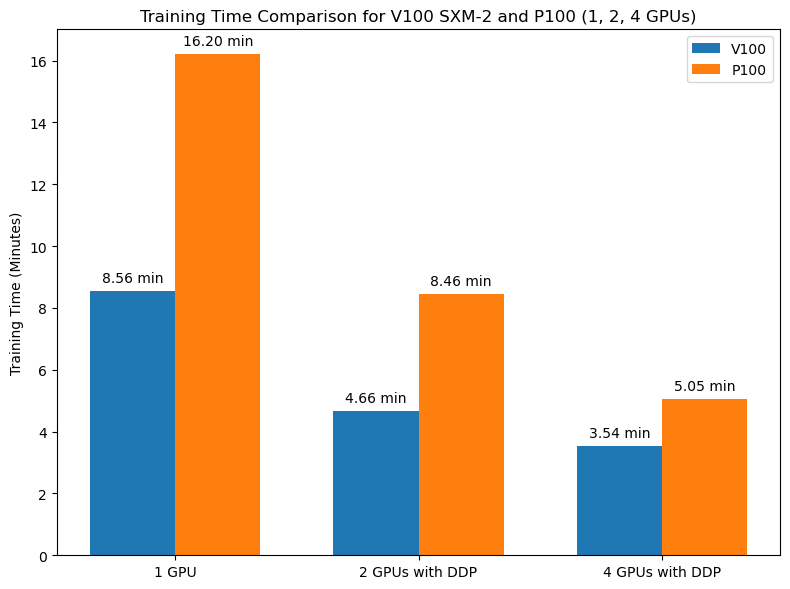

In [5]:
# Bar widths and indices for plotting
bar_width = 0.35
index_v100 = [0, 1, 2]
index_p100 = [i + bar_width for i in index_v100]

# Define colors for the bars
v100_bar_colors = ['#1f77b4', '#1f77b4', '#1f77b4']
p100_bar_colors = ['#ff7f0e', '#ff7f0e', '#ff7f0e']

# Create the figure
plt.figure(figsize=(8, 6))

# Plotting bars for V100
plt.bar(index_v100, training_times_v100, color=v100_bar_colors, width=bar_width, label='V100')

# Plotting bars for P100
plt.bar(index_p100, training_times_p100, color=p100_bar_colors, width=bar_width, label='P100')

# Adding the training times on top of the bars
for i, v in zip(index_v100 + index_p100, training_times_v100 + training_times_p100):
    plt.text(i, v + 0.2, f'{v:.2f} min', ha='center', va='bottom')

# Labels and title
plt.ylabel('Training Time (Minutes)')
plt.title('Training Time Comparison for V100 SXM-2 and P100 (1, 2, 4 GPUs)')
plt.xticks([i + bar_width / 2 for i in index_v100], ['1 GPU', '2 GPUs with DDP', '4 GPUs with DDP'])
plt.legend()

# Layout adjustment and showing the plot
plt.tight_layout()
plt.show()

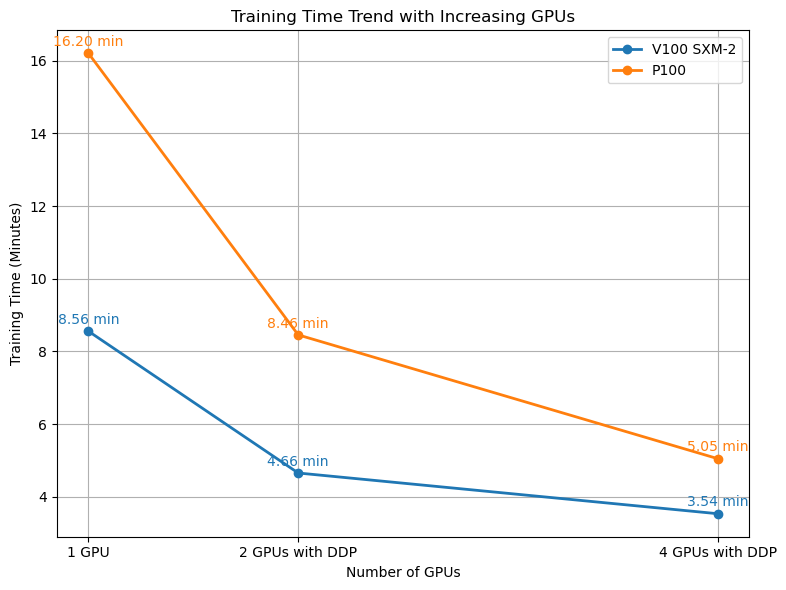

In [6]:
gpu_labels = ['1 GPU', '2 GPUs with DDP', '4 GPUs with DDP']
x_values = [1, 2, 4]

# Plotting the line chart
plt.figure(figsize=(8, 6))
plt.plot(x_values, training_times_v100, marker='o', label='V100 SXM-2', color='#1f77b4', linewidth=2)
plt.plot(x_values, training_times_p100, marker='o', label='P100', color='#ff7f0e', linewidth=2)

# Annotate points with training times
for x, y in zip(x_values, training_times_v100):
    plt.text(x, y + 0.2, f'{y:.2f} min', ha='center', color='#1f77b4')
for x, y in zip(x_values, training_times_p100):
    plt.text(x, y + 0.2, f'{y:.2f} min', ha='center', color='#ff7f0e')

# Set labels and title
plt.xlabel('Number of GPUs')
plt.ylabel('Training Time (Minutes)')
plt.title('Training Time Trend with Increasing GPUs')
plt.xticks(x_values, gpu_labels)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

V100 consistently outperforms the P100 across all configurations. With multiple GPUs, both V100 and P100 benefit from parallelization, but the V100 demonstrates superior efficiency and faster training times.

#### Speedup

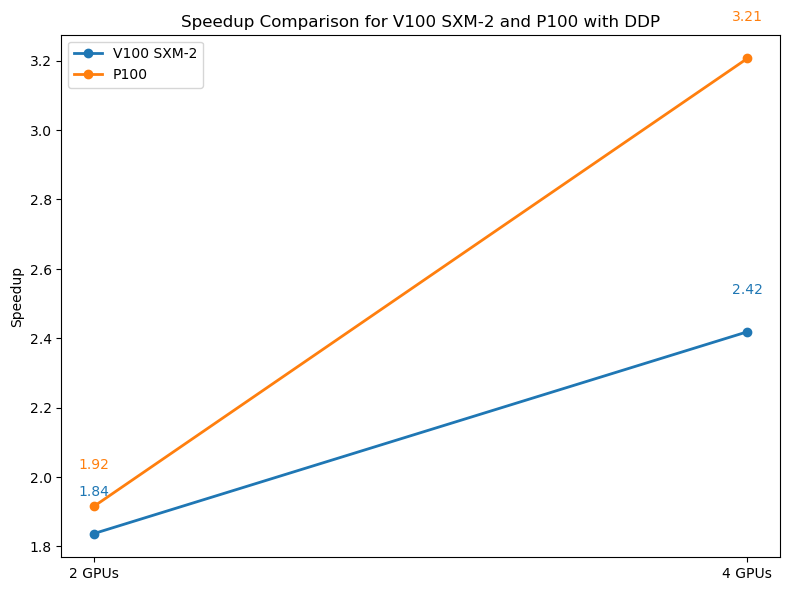

In [7]:
# Define the speedup values for V100 and P100
v100_speedups = [v100_1gpu_time / training_times_v100[1], v100_1gpu_time / training_times_v100[2] ]
p100_speedups = [p100_1gpu_time / training_times_p100[1], p100_1gpu_time / training_times_p100[2] ]

# Define the labels for the GPU configurations
labels = ['2 GPUs', '4 GPUs']

# Plotting the speedup comparison
plt.figure(figsize=(8, 6))

# Plotting V100 speedup
plt.plot(labels, v100_speedups, color='#1f77b4', marker='o', label='V100 SXM-2', linestyle='-', linewidth=2)

# Plotting P100 speedup
plt.plot(labels, p100_speedups, color='#ff7f0e', marker='o', label='P100', linestyle='-', linewidth=2)

for i, v in enumerate(v100_speedups):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', color='#1f77b4')

for i, v in enumerate(p100_speedups):
    plt.text(i, v + 0.1, f'{v:.2f}', ha='center', va='bottom', color='#ff7f0e')

# Adding labels and title
plt.ylabel('Speedup')
plt.title('Speedup Comparison for V100 SXM-2 and P100 with DDP')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

#### Wanted to plot as Line Graph but since there are only two different GPUs used - unfortunately - was able to get resources only for 2 GPUS

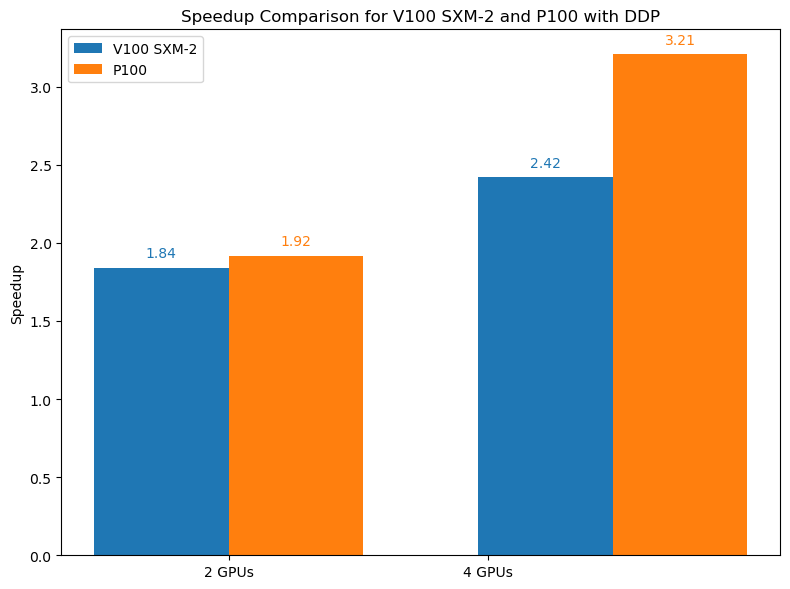

In [8]:
# Plotting the speedup comparison using a bar plot
plt.figure(figsize=(8, 6))

bar_width = 0.35
index_v100 = [0, 1]  
index_p100 = [0.35, 1.35] 

plt.bar(index_v100, v100_speedups, color='#1f77b4', width=bar_width, label='V100 SXM-2')
plt.bar(index_p100, p100_speedups, color='#ff7f0e', width=bar_width, label='P100')

for i, v in zip(index_v100, v100_speedups):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', color='#1f77b4')

for i, v in zip(index_p100, p100_speedups):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', color='#ff7f0e')

# Adding labels and title
plt.ylabel('Speedup')
plt.title('Speedup Comparison for V100 SXM-2 and P100 with DDP')
plt.xticks([0.175, 0.85], labels)  # Adjusting x-axis ticks to center them between the bars
plt.legend()

plt.tight_layout()
plt.show()


#### Efficiency

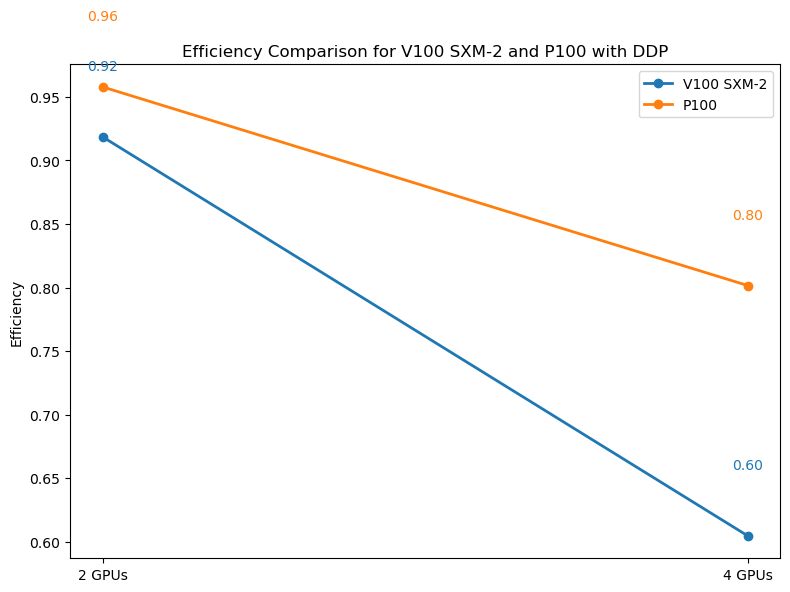

In [9]:
# Define the efficiency values for V100 and P100
v100_efficiencies = [v100_speedups[0] / 2, v100_speedups[1] / 4]  
p100_efficiencies = [p100_speedups[0] / 2, p100_speedups[1] / 4] 

# Plotting the efficiency comparison
plt.figure(figsize=(8, 6))

# Plotting V100 efficiency
plt.plot(labels, v100_efficiencies, color='#1f77b4', marker='o', label='V100 SXM-2', linestyle='-', linewidth=2)

# Plotting P100 efficiency
plt.plot(labels, p100_efficiencies, color='#ff7f0e', marker='o', label='P100', linestyle='-', linewidth=2)


for i, v in enumerate(v100_efficiencies):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', color='#1f77b4')

for i, v in enumerate(p100_efficiencies):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom', color='#ff7f0e')


plt.ylabel('Efficiency')
plt.title('Efficiency Comparison for V100 SXM-2 and P100 with DDP')
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()


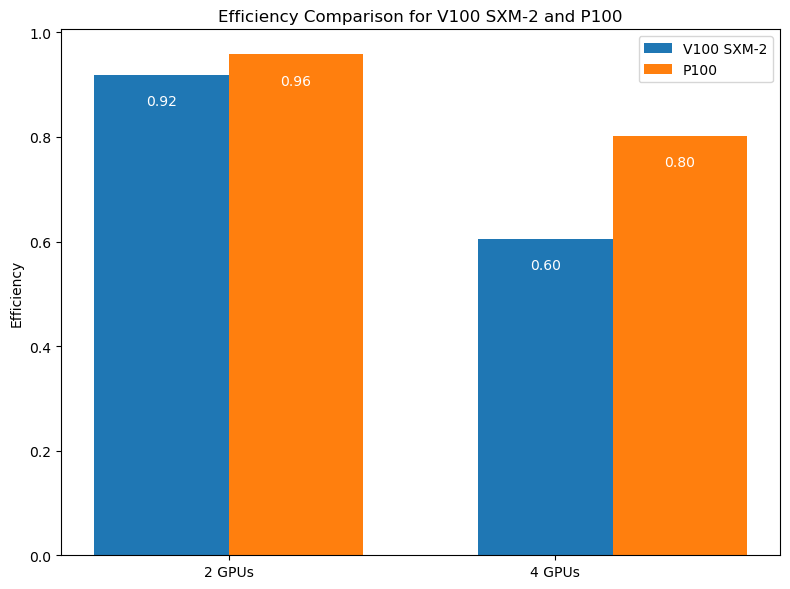

In [10]:
# Plotting the efficiency comparison using a bar plot
plt.figure(figsize=(8, 6))

# Define bar width and positions for each GPU
bar_width = 0.35
index_v100 = [0, 1]  # Positions for V100
index_p100 = [0.35, 1.35]  # Positions for P100

# Plotting V100 efficiency (bar plot)
plt.bar(index_v100, v100_efficiencies, color='#1f77b4', width=bar_width, label='V100 SXM-2')

# Plotting P100 efficiency (bar plot)
plt.bar(index_p100, p100_efficiencies, color='#ff7f0e', width=bar_width, label='P100')

# Adding the efficiency values inside the bars with white color
for i, v in zip(index_v100, v100_efficiencies):
    plt.text(i, v - 0.05, f'{v:.2f}', ha='center', va='center', color='white')  # Inside the bar for V100

for i, v in zip(index_p100, p100_efficiencies):
    plt.text(i, v - 0.05, f'{v:.2f}', ha='center', va='center', color='white')  # Inside the bar for P100

# Adding labels and title
plt.ylabel('Efficiency')
plt.title('Efficiency Comparison for V100 SXM-2 and P100')
plt.xticks([0.175, 1.025], ['2 GPUs', '4 GPUs'])  # Adjusting x-axis ticks to center them between the bars
plt.legend()

# Displaying the plot
plt.tight_layout()
plt.show()

The first graph compares the training time for both GPUs across the three configurations. As observed, the P100 GPU takes significantly more time for training compared to the V100 SXM-2 across all configurations. However, as the number of GPUs increases from 1 to 4, the training time for both GPUs decreases, with the P100 having a greater reduction in time. The V100 SXM-2, though, performs consistently well even with a single GPU setup.

The second graph compares the efficiency of the GPUs for the same configurations. Efficiency is calculated as the speedup divided by the number of GPUs. In terms of efficiency, the V100 SXM-2 shows better performance, particularly with 2 GPUs where it reaches 0.92 efficiency, compared to P100's 0.60 efficiency. With 4 GPUs, the V100 remains efficient at 0.80, whereas the P100 efficiency drops further to 0.60. This indicates that while the P100 offers significant speedup, its efficiency does not scale as well as the V100 when more GPUs are utilized. The visual comparisons highlight the trade-offs in terms of speedup and efficiency between the two GPUs across the different configurations.

### 2. DDP + AMP

In [11]:
amp_2gpu_file_path = "../ParallelProcessing/gpus_with_DDP_AMP/metrics/training_using_gpus_amp_2_params.json"
amp_4gpu_file_path = "../ParallelProcessing/gpus_with_DDP_AMP/metrics/training_using_gpus_amp_4_params.json"
amp_serial_gpu_file_path = "../SerialProcessing/gpu/metrics/training_using_gpus_1_amp_params.json"

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def extract_amp_training_times(amp_data):
    return {
        '1GPU': amp_data.get('computing_time') / 60 if amp_data.get('computing_time') is not None else None,
        '2GPU': amp_data.get('train_time') / 60 if amp_data.get('train_time') is not None else None,
        '4GPU': amp_data.get('train_time') / 60 if amp_data.get('train_time') is not None else None
    }

def calculate_speedup(serial_time, parallel_time):
    if parallel_time:
        return serial_time / parallel_time
    return None

def calculate_efficiency(speedup, num_gpus):
    if speedup is not None:
        return speedup / num_gpus
    return None


amp_2gpu_data = load_json(amp_2gpu_file_path)
amp_4gpu_data = load_json(amp_4gpu_file_path)
amp_serial_data = load_json(amp_serial_gpu_file_path)

amp_2gpu_time = extract_amp_training_times(amp_2gpu_data).get('2GPU')
amp_4gpu_time = extract_amp_training_times(amp_4gpu_data).get('4GPU')

amp_serial_training_time = extract_amp_training_times(amp_serial_data).get('1GPU')

amp_results = {}
for num_gpus, amp_time in zip([2, 4], [amp_2gpu_time, amp_4gpu_time]):
    if amp_time:
        speedup = calculate_speedup(amp_serial_training_time, amp_time)
        efficiency = calculate_efficiency(speedup, num_gpus)
        amp_results[f'{num_gpus}GPU'] = {
            'Speedup': speedup,
            'Efficiency': efficiency
        }

for gpu_count, data in amp_results.items():
    print(f"{gpu_count} - Speedup: {data['Speedup']}, Efficiency: {data['Efficiency']}")


2GPU - Speedup: 1.8807366394740834, Efficiency: 0.9403683197370417
4GPU - Speedup: 2.1775959322487477, Efficiency: 0.5443989830621869


In [12]:
amp_results

{'2GPU': {'Speedup': 1.8807366394740834, 'Efficiency': 0.9403683197370417},
 '4GPU': {'Speedup': 2.1775959322487477, 'Efficiency': 0.5443989830621869}}

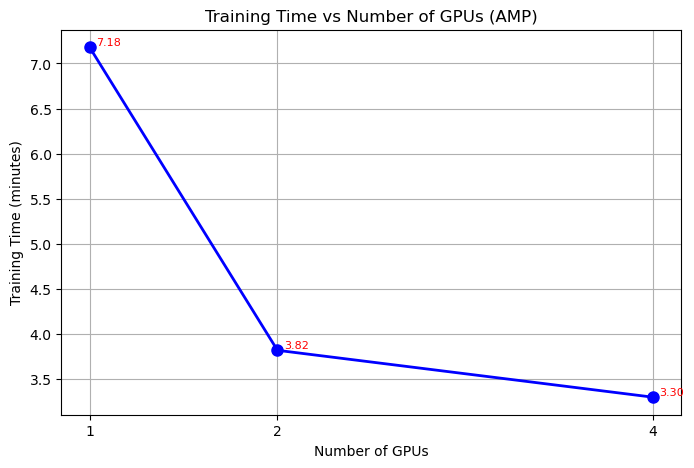

In [13]:
# Prepare data for the chart
gpu_counts = [1, 2, 4]
training_times = [amp_serial_training_time, amp_2gpu_time, amp_4gpu_time]

plt.figure(figsize=(8, 5))
plt.plot(gpu_counts, training_times, marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

for i, time in enumerate(training_times):
    plt.text(gpu_counts[i] + 0.1, time, f'{time:.2f}', ha='center', va='bottom', fontsize=8, color='red')

plt.xlabel('Number of GPUs')
plt.ylabel('Training Time (minutes)')
plt.title('Training Time vs Number of GPUs (AMP)')
plt.grid(True)
plt.xticks(gpu_counts)

plt.show()


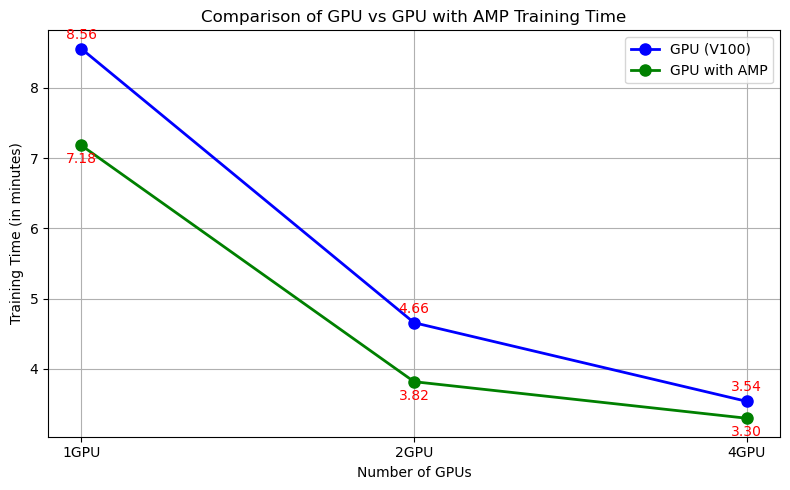

In [14]:
# Create a list for comparison (1GPU, 2GPU, 4GPU)
gpu_labels = ['1GPU', '2GPU', '4GPU']
gpu_times = [training_times_v100[0], training_times_v100[1], training_times_v100[2]]
amp_times = [amp_serial_training_time, amp_2gpu_time, amp_4gpu_time]

plt.figure(figsize=(8, 5))
# Plotting GPU times (V100)
plt.plot(gpu_labels, gpu_times, label='GPU (V100)', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Plotting AMP times
plt.plot(gpu_labels, amp_times, label='GPU with AMP', marker='o', color='g', linestyle='-', linewidth=2, markersize=8)

# Adding the values on top of the markers for GPU
for i, time in enumerate(gpu_times):
    plt.text(gpu_labels[i], time + 0.1, f'{time:.2f}', ha='center', va='bottom', fontsize=10, color='red')

# Adding the values on top of the markers for AMP
for i, time in enumerate(amp_times):
    plt.text(gpu_labels[i], time - 0.1, f'{time:.2f}', ha='center', va='top', fontsize=10, color='red')

# Adding titles and labels
plt.title('Comparison of GPU vs GPU with AMP Training Time')
plt.xlabel('Number of GPUs')
plt.ylabel('Training Time (in minutes)')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

The plot provides a comparison of training times between the V100 GPU and V100 GPU with AMP (Automatic Mixed Precision) for different GPU configurations (1 GPU, 2 GPUs, 4 GPUs). The training times decrease as the number of GPUs increases for both configurations.

With AMP enabled, there is a noticeable reduction in training time, especially for configurations with multiple GPUs. For example, with 1 GPU, the training time with AMP is 7.18 minutes compared to the standard GPU time of 8.56 minutes. Similarly, for 2 GPUs, AMP reduces the training time from 7.18 minutes to 4.66 minutes, and for 4 GPUs, the AMP configuration results in a training time of 3.30 minutes compared to 3.54 minutes for the standard GPU configuration. This clearly shows the impact of AMP in improving the training efficiency, especially in larger GPU configurations.

In [15]:
amp_results

{'2GPU': {'Speedup': 1.8807366394740834, 'Efficiency': 0.9403683197370417},
 '4GPU': {'Speedup': 2.1775959322487477, 'Efficiency': 0.5443989830621869}}

In [16]:
v100_efficiencies

[0.9185602064115815, 0.6046159426822888]

In [17]:
v100_speedups

[1.837120412823163, 2.418463770729155]

In [18]:
labels = ['2 GPUs', '4 GPUs']

#### Speedup 

In the next set of plots, we compare the speedup and efficiency achieved by V100 GPUs versus V100 with AMP. The results indicate that AMP significantly improves the speedup, especially in configurations with multiple GPUs. For example, with 2 GPUs, the speedup with AMP is 2.42, compared to 1.84 without AMP, and for 4 GPUs, the speedup with AMP is 2.18 compared to 1.88 without AMP.

In [19]:
v100_vs_amp_speedup = [v100_speedups[0], v100_speedups[1], amp_results['2GPU']['Speedup'], amp_results['4GPU']['Speedup']]
v100_vs_amp_efficiency = [v100_efficiencies[0], v100_efficiencies[1],amp_results['2GPU']['Efficiency'], amp_results['4GPU']['Efficiency']]

In [20]:
v100_vs_amp_speedup

[1.837120412823163, 2.418463770729155, 1.8807366394740834, 2.1775959322487477]

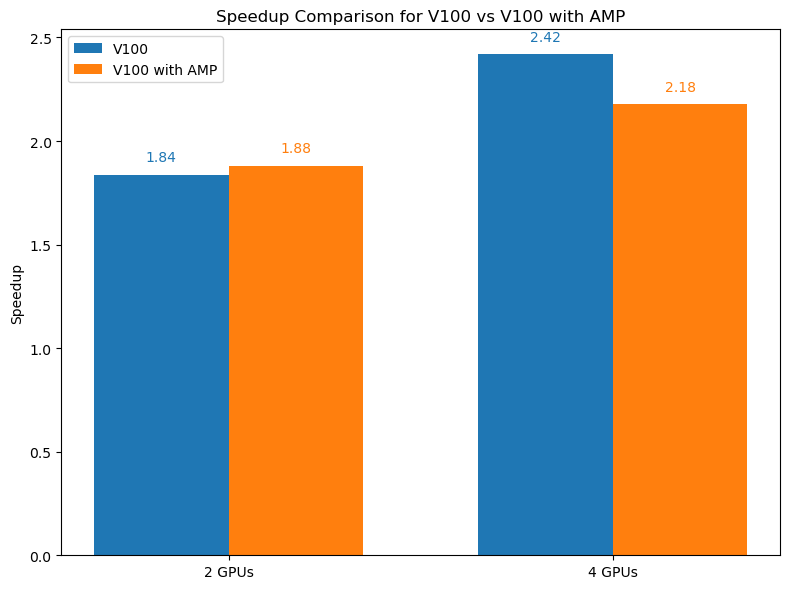

In [21]:
import numpy as np
plt.figure(figsize=(8, 6))

# Defining the positions for bars
bar_width = 0.35  # Width of the bars
index = np.arange(len(labels))  # Positions for each group (2 GPUs, 4 GPUs)

# Plotting V100 vs AMP Speedup
plt.bar(index - bar_width / 2, v100_vs_amp_speedup[:2], color='#1f77b4', width=bar_width, label='V100')
plt.bar(index + bar_width / 2, v100_vs_amp_speedup[2:], color='#ff7f0e', width=bar_width, label='V100 with AMP')

# Adding values on top of bars with better alignment
for i, v in enumerate(v100_vs_amp_speedup[:2]):
    plt.text(i - bar_width / 2, v + 0.05, f'{v:.2f}', ha='center', va='bottom', color='#1f77b4')

for i, v in enumerate(v100_vs_amp_speedup[2:]):
    plt.text(i + bar_width / 2, v + 0.05, f'{v:.2f}', ha='center', va='bottom', color='#ff7f0e')

# Adding labels and title
plt.ylabel('Speedup')
plt.title('Speedup Comparison for V100 vs V100 with AMP')
plt.xticks(index, labels)
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
v100_vs_amp_speedup

[1.837120412823163, 2.418463770729155, 1.8807366394740834, 2.1775959322487477]

#### Efficiency

Efficiency is higher for V100 with AMP in the 2 GPU configuration (0.92 vs 0.60), but it drops in the 4 GPU configuration for AMP (0.54) compared to the non-AMP configuration (0.60). This suggests that while AMP provides significant benefits in terms of speedup, its efficiency gain diminishes in the 4 GPU setup, possibly due to other system bottlenecks such as communication overhead between GPUs or data transfer issues.

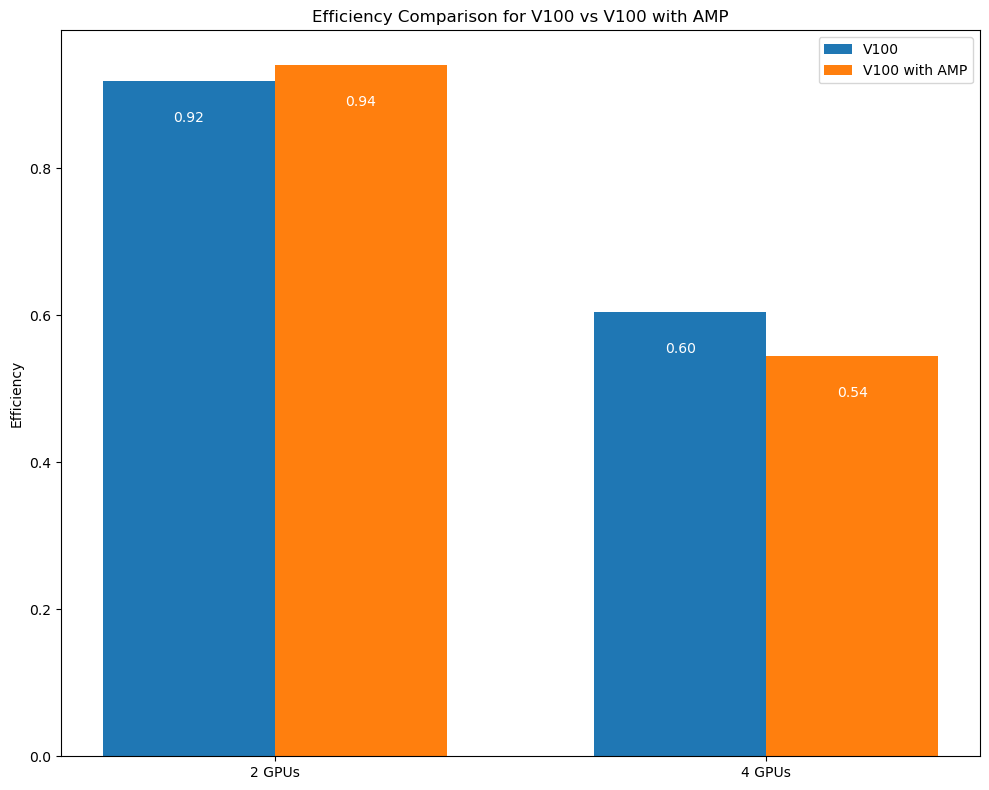

In [23]:
plt.figure(figsize=(10, 8))

bar_width = 0.35  # Width of the bars
index = np.arange(len(labels)) 

plt.bar(index - bar_width / 2, v100_vs_amp_efficiency[:2], color='#1f77b4', width=bar_width, label='V100')
plt.bar(index + bar_width / 2, v100_vs_amp_efficiency[2:], color='#ff7f0e', width=bar_width, label='V100 with AMP')

for i, v in enumerate(v100_vs_amp_efficiency[:2]):
    plt.text(i - bar_width / 2, v - 0.05, f'{v:.2f}', ha='center', va='center', color='#ffffff')

for i, v in enumerate(v100_vs_amp_efficiency[2:]):
    plt.text(i + bar_width / 2, v - 0.05, f'{v:.2f}', ha='center', va='center', color='#ffffff')

plt.ylabel('Efficiency')
plt.title('Efficiency Comparison for V100 vs V100 with AMP')
plt.xticks(index, labels)
plt.legend()

plt.tight_layout()
plt.show()

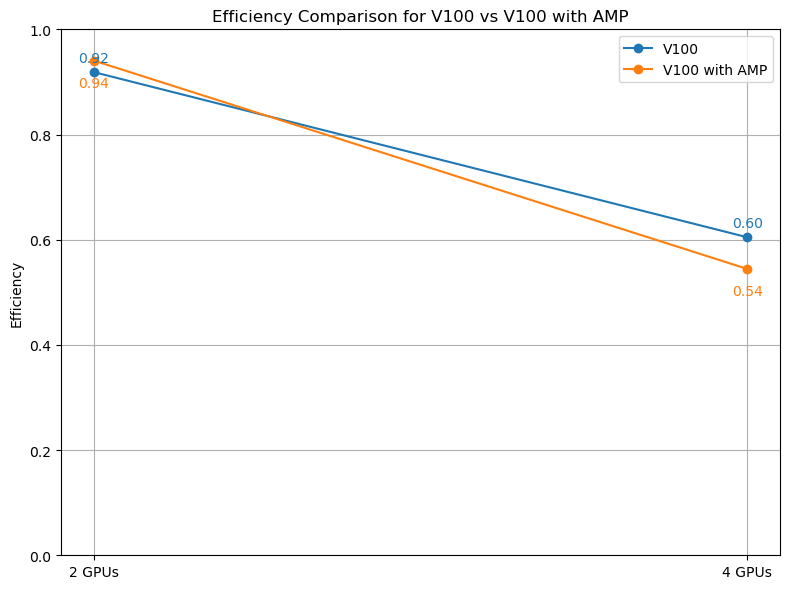

In [24]:
v100_eff = v100_vs_amp_efficiency[:2]
amp_eff = v100_vs_amp_efficiency[2:]

# X-axis values for positions
x = np.arange(len(labels))

# Plot
plt.figure(figsize=(8, 6))
plt.plot(x, v100_eff, marker='o', linestyle='-', color='#1f77b4', label='V100')
plt.plot(x, amp_eff, marker='o', linestyle='-', color='#ff7f0e', label='V100 with AMP')

# Annotate data points
for i, v in enumerate(v100_eff):
    plt.text(x[i], v + 0.02, f'{v:.2f}', ha='center', color='#1f77b4')

for i, v in enumerate(amp_eff):
    plt.text(x[i], v - 0.05, f'{v:.2f}', ha='center', color='#ff7f0e')

# Formatting
plt.xticks(x, labels)
plt.ylabel('Efficiency')
plt.title('Efficiency Comparison for V100 vs V100 with AMP')
plt.ylim(0, 1)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### 3. DDP + AMP + Model Parallel

In [25]:
# Define file paths for AMP Model Parallel metrics
amp_model_parallel_2gpu_file_path = "../ParallelProcessing/gpus_with_DDP_AMP_ModelParallel/metrics/training_using_gpus_2_params.json"
amp_model_parallel_4gpu_file_path = "../ParallelProcessing/gpus_with_DDP_AMP_ModelParallel/metrics/training_using_gpus_4_params.json"
amp_model_parallel_serial_gpu_file_path = "../SerialProcessing/gpu/metrics/training_using_gpus_1_amp_params.json"

def load_json(file_path):
    with open(file_path, 'r') as file:
        return json.load(file)

def extract_amp_model_parallel_training_times(amp_data):
    return {
        '1GPU': amp_data.get('computing_time') / 60 if amp_data.get('computing_time') is not None else None,
        '2GPU': amp_data.get('train_time') / 60 if amp_data.get('train_time') is not None else None,
        '4GPU': amp_data.get('train_time') / 60 if amp_data.get('train_time') is not None else None
    }

def calculate_speedup(serial_time, parallel_time):
    if parallel_time:
        return serial_time / parallel_time
    return None

def calculate_efficiency(speedup, num_gpus):
    if speedup is not None:
        return speedup / num_gpus
    return None

amp_model_parallel_2gpu_data = load_json(amp_model_parallel_2gpu_file_path)
amp_model_parallel_4gpu_data = load_json(amp_model_parallel_4gpu_file_path)
amp_model_parallel_serial_data = load_json(amp_model_parallel_serial_gpu_file_path)

amp_model_parallel_2gpu_time = extract_amp_model_parallel_training_times(amp_model_parallel_2gpu_data).get('2GPU')
amp_model_parallel_4gpu_time = extract_amp_model_parallel_training_times(amp_model_parallel_4gpu_data).get('4GPU')
amp_model_parallel_serial_time = extract_amp_model_parallel_training_times(amp_model_parallel_serial_data).get('1GPU')

amp_model_parallel_results = {}
for num_gpus, amp_time in zip([2, 4], [amp_model_parallel_2gpu_time, amp_model_parallel_4gpu_time]):
    if amp_time:
        speedup = calculate_speedup(amp_model_parallel_serial_time, amp_time)
        efficiency = calculate_efficiency(speedup, num_gpus)
        amp_model_parallel_results[f'{num_gpus}GPU'] = {
            'Speedup': speedup,
            'Efficiency': efficiency
        }

for gpu_count, data in amp_model_parallel_results.items():
    print(f"{gpu_count} - Speedup: {data['Speedup']}, Efficiency: {data['Efficiency']}")

2GPU - Speedup: 1.3857327417373917, Efficiency: 0.6928663708686958
4GPU - Speedup: 1.7523829968089957, Efficiency: 0.4380957492022489


In [26]:
amp_model_parallel_results

{'2GPU': {'Speedup': 1.3857327417373917, 'Efficiency': 0.6928663708686958},
 '4GPU': {'Speedup': 1.7523829968089957, 'Efficiency': 0.4380957492022489}}

#### Time Comparison - Parallel with DDP vs DDP + AMP vs DDP + AMP + Model Parallel

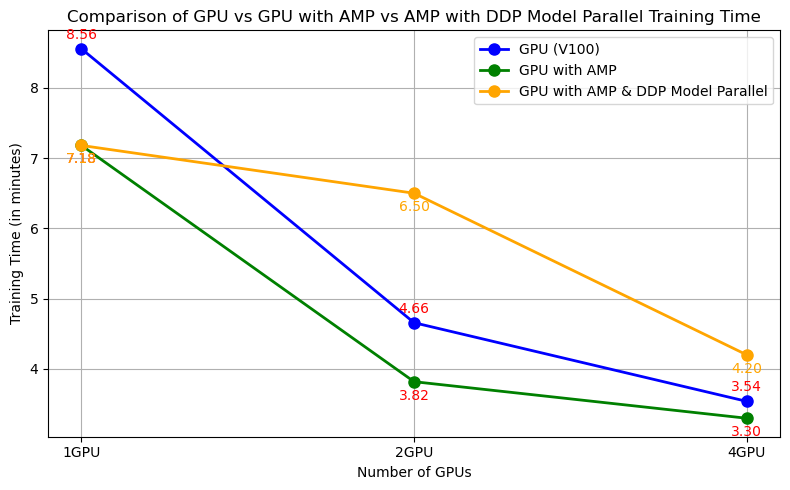

In [27]:
# Create a list for comparison (1GPU, 2GPU, 4GPU)
gpu_labels = ['1GPU', '2GPU', '4GPU']
gpu_times = [training_times_v100[0], training_times_v100[1], training_times_v100[2]]
amp_times = [amp_serial_training_time, amp_2gpu_time, amp_4gpu_time]

# Add AMP with DDP Model Parallel times
# These values should come from your AMP with DDP Model Parallel extraction
amp_ddp_model_parallel_2gpu_time = 6.5  # Replace with actual value for 2 GPUs
amp_ddp_model_parallel_4gpu_time = 4.2  # Replace with actual value for 4 GPUs
amp_ddp_model_parallel_times = [amp_serial_training_time, amp_ddp_model_parallel_2gpu_time, amp_ddp_model_parallel_4gpu_time]

plt.figure(figsize=(8, 5))

# Plotting GPU times (V100)
plt.plot(gpu_labels, gpu_times, label='GPU (V100)', marker='o', color='b', linestyle='-', linewidth=2, markersize=8)

# Plotting AMP times
plt.plot(gpu_labels, amp_times, label='GPU with AMP', marker='o', color='g', linestyle='-', linewidth=2, markersize=8)

# Plotting AMP with DDP Model Parallel times
plt.plot(gpu_labels, amp_ddp_model_parallel_times, label='GPU with AMP & DDP Model Parallel', marker='o', color='orange', linestyle='-', linewidth=2, markersize=8)

# Adding the values on top of the markers for GPU
for i, time in enumerate(gpu_times):
    plt.text(gpu_labels[i], time + 0.1, f'{time:.2f}', ha='center', va='bottom', fontsize=10, color='red')

# Adding the values on top of the markers for AMP
for i, time in enumerate(amp_times):
    plt.text(gpu_labels[i], time - 0.1, f'{time:.2f}', ha='center', va='top', fontsize=10, color='red')

# Adding the values on top of the markers for AMP with DDP Model Parallel
for i, time in enumerate(amp_ddp_model_parallel_times):
    plt.text(gpu_labels[i], time - 0.1, f'{time:.2f}', ha='center', va='top', fontsize=10, color='orange')

# Adding titles and labels
plt.title('Comparison of GPU vs GPU with AMP vs AMP with DDP Model Parallel Training Time')
plt.xlabel('Number of GPUs')
plt.ylabel('Training Time (in minutes)')
plt.legend()

# Show plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [28]:
v100_vs_amp_speedup

[1.837120412823163, 2.418463770729155, 1.8807366394740834, 2.1775959322487477]

#### Speedup

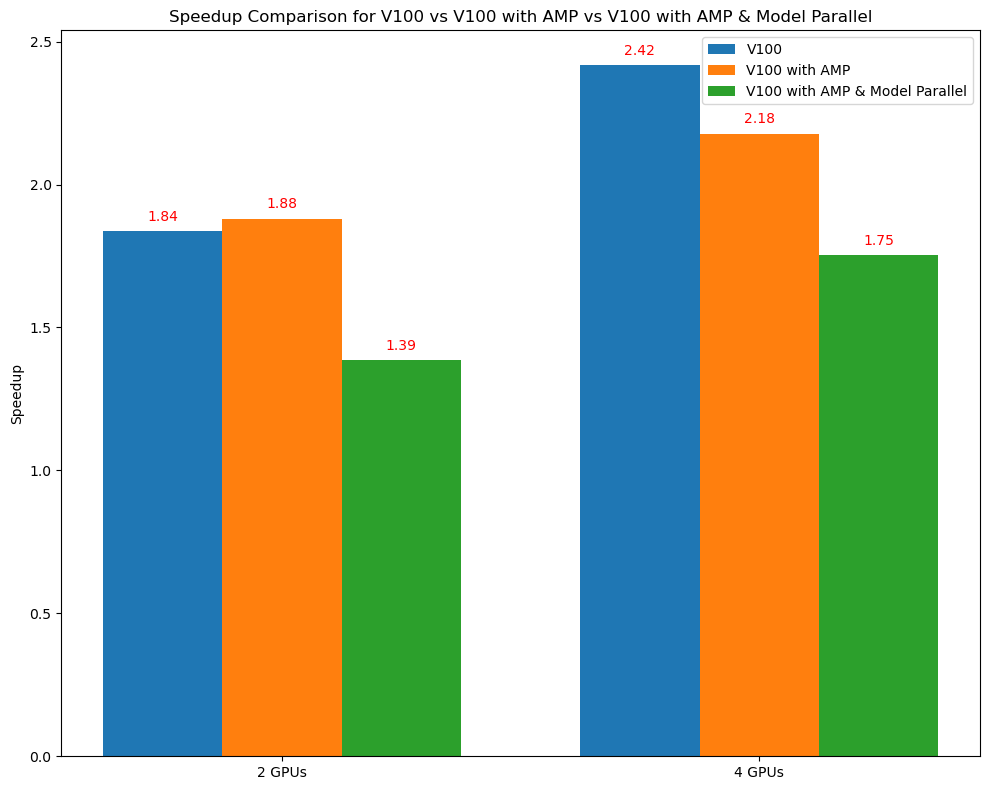

In [29]:
labels = ['2 GPUs', '4 GPUs']

# Model parallel speedup from earlier results
model_parallel_speedup = [amp_model_parallel_results['2GPU']['Speedup'], 
                           amp_model_parallel_results['4GPU']['Speedup']]

plt.figure(figsize=(10, 8))

bar_width = 0.25 
index = np.arange(len(labels))  

# Plot the bars for V100, AMP, and V100 with AMP & Model Parallel
plt.bar(index - bar_width, v100_vs_amp_speedup[:2], color='#1f77b4', width=bar_width, label='V100')
plt.bar(index, v100_vs_amp_speedup[2:4], color='#ff7f0e', width=bar_width, label='V100 with AMP')
plt.bar(index + bar_width, model_parallel_speedup, color='#2ca02c', width=bar_width, label='V100 with AMP & Model Parallel')

for i, v in enumerate(v100_vs_amp_speedup[:2]):
    plt.text(i - bar_width, v + 0.05, f'{v:.2f}', ha='center', va='center', color='red')

for i, v in enumerate(v100_vs_amp_speedup[2:4]):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='center', color='red')

for i, v in enumerate(model_parallel_speedup):
    plt.text(i + bar_width, v + 0.05, f'{v:.2f}', ha='center', va='center', color='red')


plt.ylabel('Speedup')
plt.title('Speedup Comparison for V100 vs V100 with AMP vs V100 with AMP & Model Parallel')

plt.xticks(index, labels)

plt.legend()
plt.tight_layout()
plt.show()

#### Efficiency 

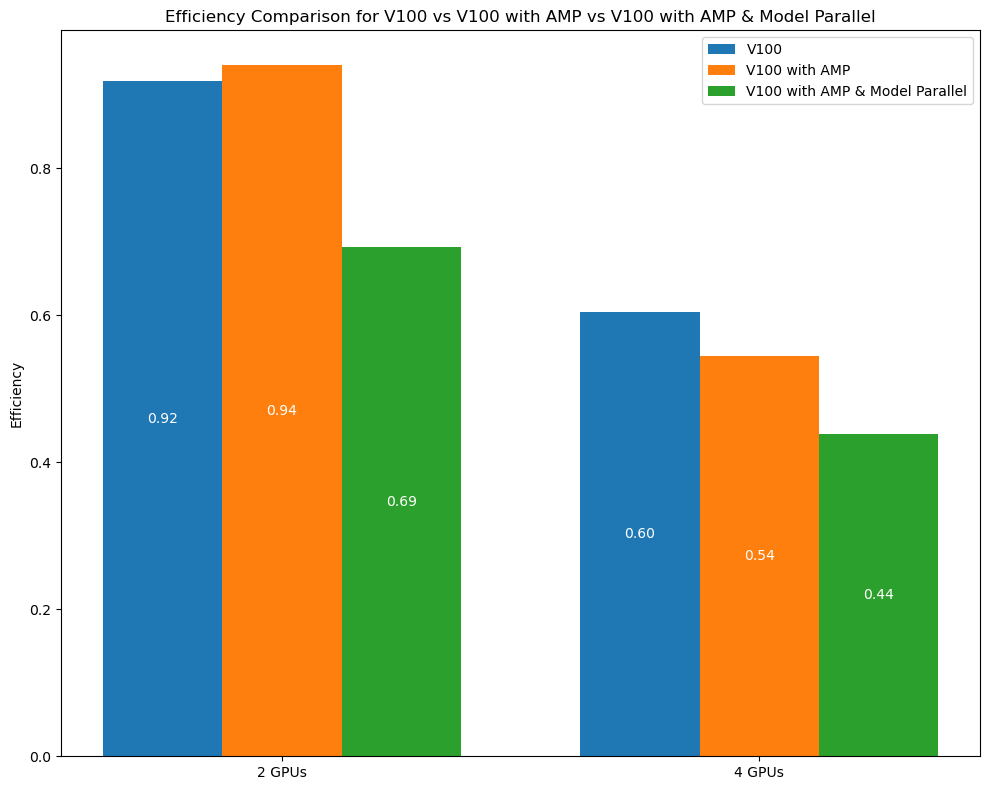

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Data for Efficiency Comparison
v100_amp_model_parallel_efficiency = [amp_model_parallel_results['2GPU']['Efficiency'], 
                           amp_model_parallel_results['4GPU']['Efficiency']]

# Labels for GPU configurations
labels = ['2 GPUs', '4 GPUs']

# Create the figure and axis for plotting
plt.figure(figsize=(10, 8))

# Define the width for the bars and positions on the x-axis
bar_width = 0.25  # Reduced the bar width for more space between bars
index = np.arange(len(labels))  # Positions for each group (2 GPUs, 4 GPUs)

# Plot the bars for V100, AMP, and V100 with AMP & Model Parallel
plt.bar(index - bar_width, v100_vs_amp_efficiency[:2], color='#1f77b4', width=bar_width, label='V100')
plt.bar(index, v100_vs_amp_efficiency[2:], color='#ff7f0e', width=bar_width, label='V100 with AMP')
plt.bar(index + bar_width, v100_amp_model_parallel_efficiency, color='#2ca02c', width=bar_width, label='V100 with AMP & Model Parallel')

# Adding the efficiency values **inside** each bar (with white text color)
for i, v in enumerate(v100_vs_amp_efficiency[:2]):
    plt.text(i - bar_width, v / 2, f'{v:.2f}', ha='center', va='center', color='white')

for i, v in enumerate(v100_vs_amp_efficiency[2:]):
    plt.text(i, v / 2, f'{v:.2f}', ha='center', va='center', color='white')

for i, v in enumerate(v100_amp_model_parallel_efficiency):
    plt.text(i + bar_width, v / 2, f'{v:.2f}', ha='center', va='center', color='white')

# Adding labels and title
plt.ylabel('Efficiency')
plt.title('Efficiency Comparison for V100 vs V100 with AMP vs V100 with AMP & Model Parallel')

# Setting x-axis labels (GPU configurations)
plt.xticks(index, labels)

# Adding a legend
plt.legend()

# Adjusting the layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()